# Means Across Years Plot

In this notebook, we will use the filtered freshwater runoff data, the chlorophyll data, and se ice concentration to create figure 3

### Data needed to create this figure: 

#### Fjord Polygons Shapefiles:
Download it here: [Fjord Shapefiles](https://drive.google.com/file/d/1lEkHKa-Fgl-UknROEccnuc2W59ui6C0F/view?usp=drive_link)

#### Cholorphyll Data:
Download it here: [Chlorophyll Data](https://drive.google.com/drive/folders/1LfConKMAZuFDirtopHF6cCnxKPjTdAO5?usp=drive_link)

#### Freshwater Runoff:
Create it with [notebooks/freshwater_runnoff.ipynb](https://github.com/tparker1/agu24/blob/main/notebooks/freshwater_runoff.ipynb) or download it here: [filtered freshwater data](https://drive.google.com/drive/folders/1Ci5FrHsG7j237Tpu75r_tUvqdVijSPcG?usp=drive_link)

#### Sea Ice Concentration
Create it with [awaiting upload]() or download it here: [Sea Ice Concentration](https://drive.google.com/file/d/1D5GQaqI3uB86LpBu-avzz_O0RV2vpMJ-/view?usp=drive_link)

In [2]:
# system
import os
import pickle

# data manipulation
import xarray as xr
import pandas as pd
import geopandas as gpd
from scipy.signal import savgol_filter

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.lines as mlines
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from cycler import cycler

# spatial
import geopandas as gpd
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

# helper functions
import sys
sys.path.append(os.path.abspath('/home/tara/Documents/mlml/agu24/scripts'))
import common_methods as cm

### Read in the fjord polygons

In [3]:
fjord_polygon_filepath = os.path.expanduser('~/Data/Polygons/Greenland_ExtRegions/Greenland_ExtRegions_Master_20240711.shp')
polygons = gpd.read_file(fjord_polygon_filepath)
region_to_group_map = {region: group for region, group in zip(polygons['id'], polygons['group'])}

region_locations = {0: (-29.994791666666686,68.13020833333334),
                    1: (-22.026041666666686, 76.703125),
                    2: (-21.546875, 77.72395833333333),
                    3: (-70.671875, 76.734375),
                    4: (-55.81770833333334, 73.59895833333334),
                    5: (-55.63020833333334, 72.93229166666667),
                    6: (-53.18229166666667, 71.43229166666667),
                    7: (-52.046875, 69.96354166666667)}
region_names_map = {0: 'h) Kangerdlugssuaq',
                    1: 'g) Storstrommen',
                    2: 'f) Zachariae',
                    3: 'a) Qannaq',
                    4: 'b) Kakivfaat',
                    5: 'c) Upernavik',
                    6: 'd) Ummannaq',
                    7: 'j) Torsukataq'}

fjord_master = cm.load_region_polygons()

polygons

,id,fjords,gates,glaciers,group,geometry
0,0,fjord042,197,"Kangerlussuaq, Frederiksborg, Nordfjord, Styrt...",12,"POLYGON ((-32.98412 68.62557, -32.59627 68.582..."
1,1,"fjord080, fjord081",-1,Storstrommen,9,"POLYGON ((-22.24036 76.84836, -22.12303 76.844..."
2,2,"fjord090, fjord091",28,"Kofoed, Zachariae",9,"POLYGON ((-22.06520 77.55814, -21.65192 77.953..."
3,3,"fjord125, fjord126",43,"Berlingske, Harald Moltke, Knud Rasmussen, Cha...",5,"POLYGON ((-68.71621 76.56921, -70.68554 76.727..."
4,4,"fjord146, fjord147","126, 128","Kakivfaat, Nunatakassaap",4,"POLYGON ((-55.45556 73.45953, -55.42344 73.458..."
5,5,"fjord148, fjord149","130, 132","Upernavik Isstrom C, Upernavik Isstrom N, Uper...",4,"POLYGON ((-55.90841 73.00115, -55.86592 73.003..."
6,6,"fjord156, fjord157","139, 141","Rink Isbrae, Kangerlussuup",4,"POLYGON ((-52.54100 71.32727, -52.82646 71.359..."
7,7,"fjord164, fjord165","165, 176","Sermeq Avannarleq, Kujalleq, Kangilernata, Eqi...",3,"POLYGON ((-50.65791 69.75950, -50.80724 69.790..."


### Read in the processed sea ice daily stats

In [4]:
seaice_fp = os.path.expanduser('~/Documents/mlml/agu24/data/seaice_daily_stats.pkl')
with open(seaice_fp, 'rb') as f:
    seaice_daily_mean, seaice_daily_median, seaice_daily_q1, seaice_daily_q3 = pickle.load(f)


start = '1998-01-01'
end = '2024-01-01'

### Specify the filtered freshwater and chlorophyll data locations

In [5]:
filtered_data_fp = '/home/tara/Data/Mankoff/filtered_data/'
chla_fjord_folder = '/home/tara/Data/CSVs/extended_fjords'

## Create the Plot
### Visualize the color palette 

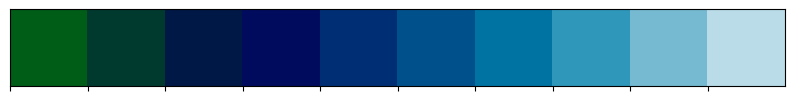

In [6]:
palette = sns.color_palette("ocean", 10)
sns.palplot(palette)
plt.show()

### Set some plot options

In [7]:
discharge_color = sns.color_palette("ocean", 10)[-5]
ice_color = sns.color_palette("ocean", 10)[-2]
chl_color = sns.color_palette("ocean", 10)[0]
blue_color = sns.color_palette("Paired")[1]

palette = [sns.color_palette("husl", 8)[i] for i in [0, 4, 1, 5, 2, 6, 3, 7]]


start_date = pd.to_datetime('2000-04-05')
end_date = pd.to_datetime('2000-09-25')

new_order = [3, 2, 4, 1, 5, 0, 6, 7]
count = -1

textfontsize = 28

### SavGol Filter
Learn more about SavGol: [Savitzky–Golay filter](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter)

Basically, the idea is to compute an average for each day in a year of all the data over 25 years (eg. 01/01/1998, 01/01/1999, ..., 01/01/2023). Because this is inheriently noisy, we use a SavGol filter to approximate the curve. The result is visually similar to the moving average, but smoother. 

In [8]:
def convert_and_smooth(ds, window, discharge=False):
    if discharge:
        # Convert the dataset to pandas DataFrame
        temp_ds = ds.to_dataframe(name='discharge')
        
        # Apply Savitzky-Golay filter
        smoothed = savgol_filter(temp_ds['discharge'].values, window, 2)
        
        # Convert the smoothed data back to xarray DataArray
        smoothed_ds = xr.DataArray(smoothed, dims=['month_day'], coords={'month_day': ds['month_day'], 'date': ds['date']})

    else:
        daily_series = ds['dayofyear'].to_pandas()
        # create dummy dates for the 'dayofyear'
        dates = pd.to_datetime('2000-01-01') + pd.to_timedelta(daily_series - 1, unit='D')  # dummy year
        ds['dayofyear'] = xr.DataArray(dates, dims=['dayofyear'])
        temp_ds = ds.to_dataframe(name='cdr_seaice_conc')
        smoothed = savgol_filter(temp_ds['cdr_seaice_conc'].values, window, 2)
        smoothed_ds = xr.DataArray(smoothed, dims=['dayofyear'], coords={'dayofyear': ds['dayofyear']})
        
    return smoothed_ds

def seaice_dates(ds):
    daily_series = ds['dayofyear'].to_pandas()
    dates = pd.to_datetime('2000-01-01') + pd.to_timedelta(daily_series - 1, unit='D')  # dummy year
    ds['dayofyear'] = xr.DataArray(dates, dims=['dayofyear'])
    return ds

In [9]:
# A bit hacky here, but it works and I am low on time :) 
fjord_indexes = {0: (50, 77),
                1: (52, 36),
                2: (49, 29),
                3: (3, 35),
                4: (13, 54),
                5: (13, 56),
                6: (15, 63),
                7: (17, 70)}

/tmp/ipykernel_78962/3196449968.py:167: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


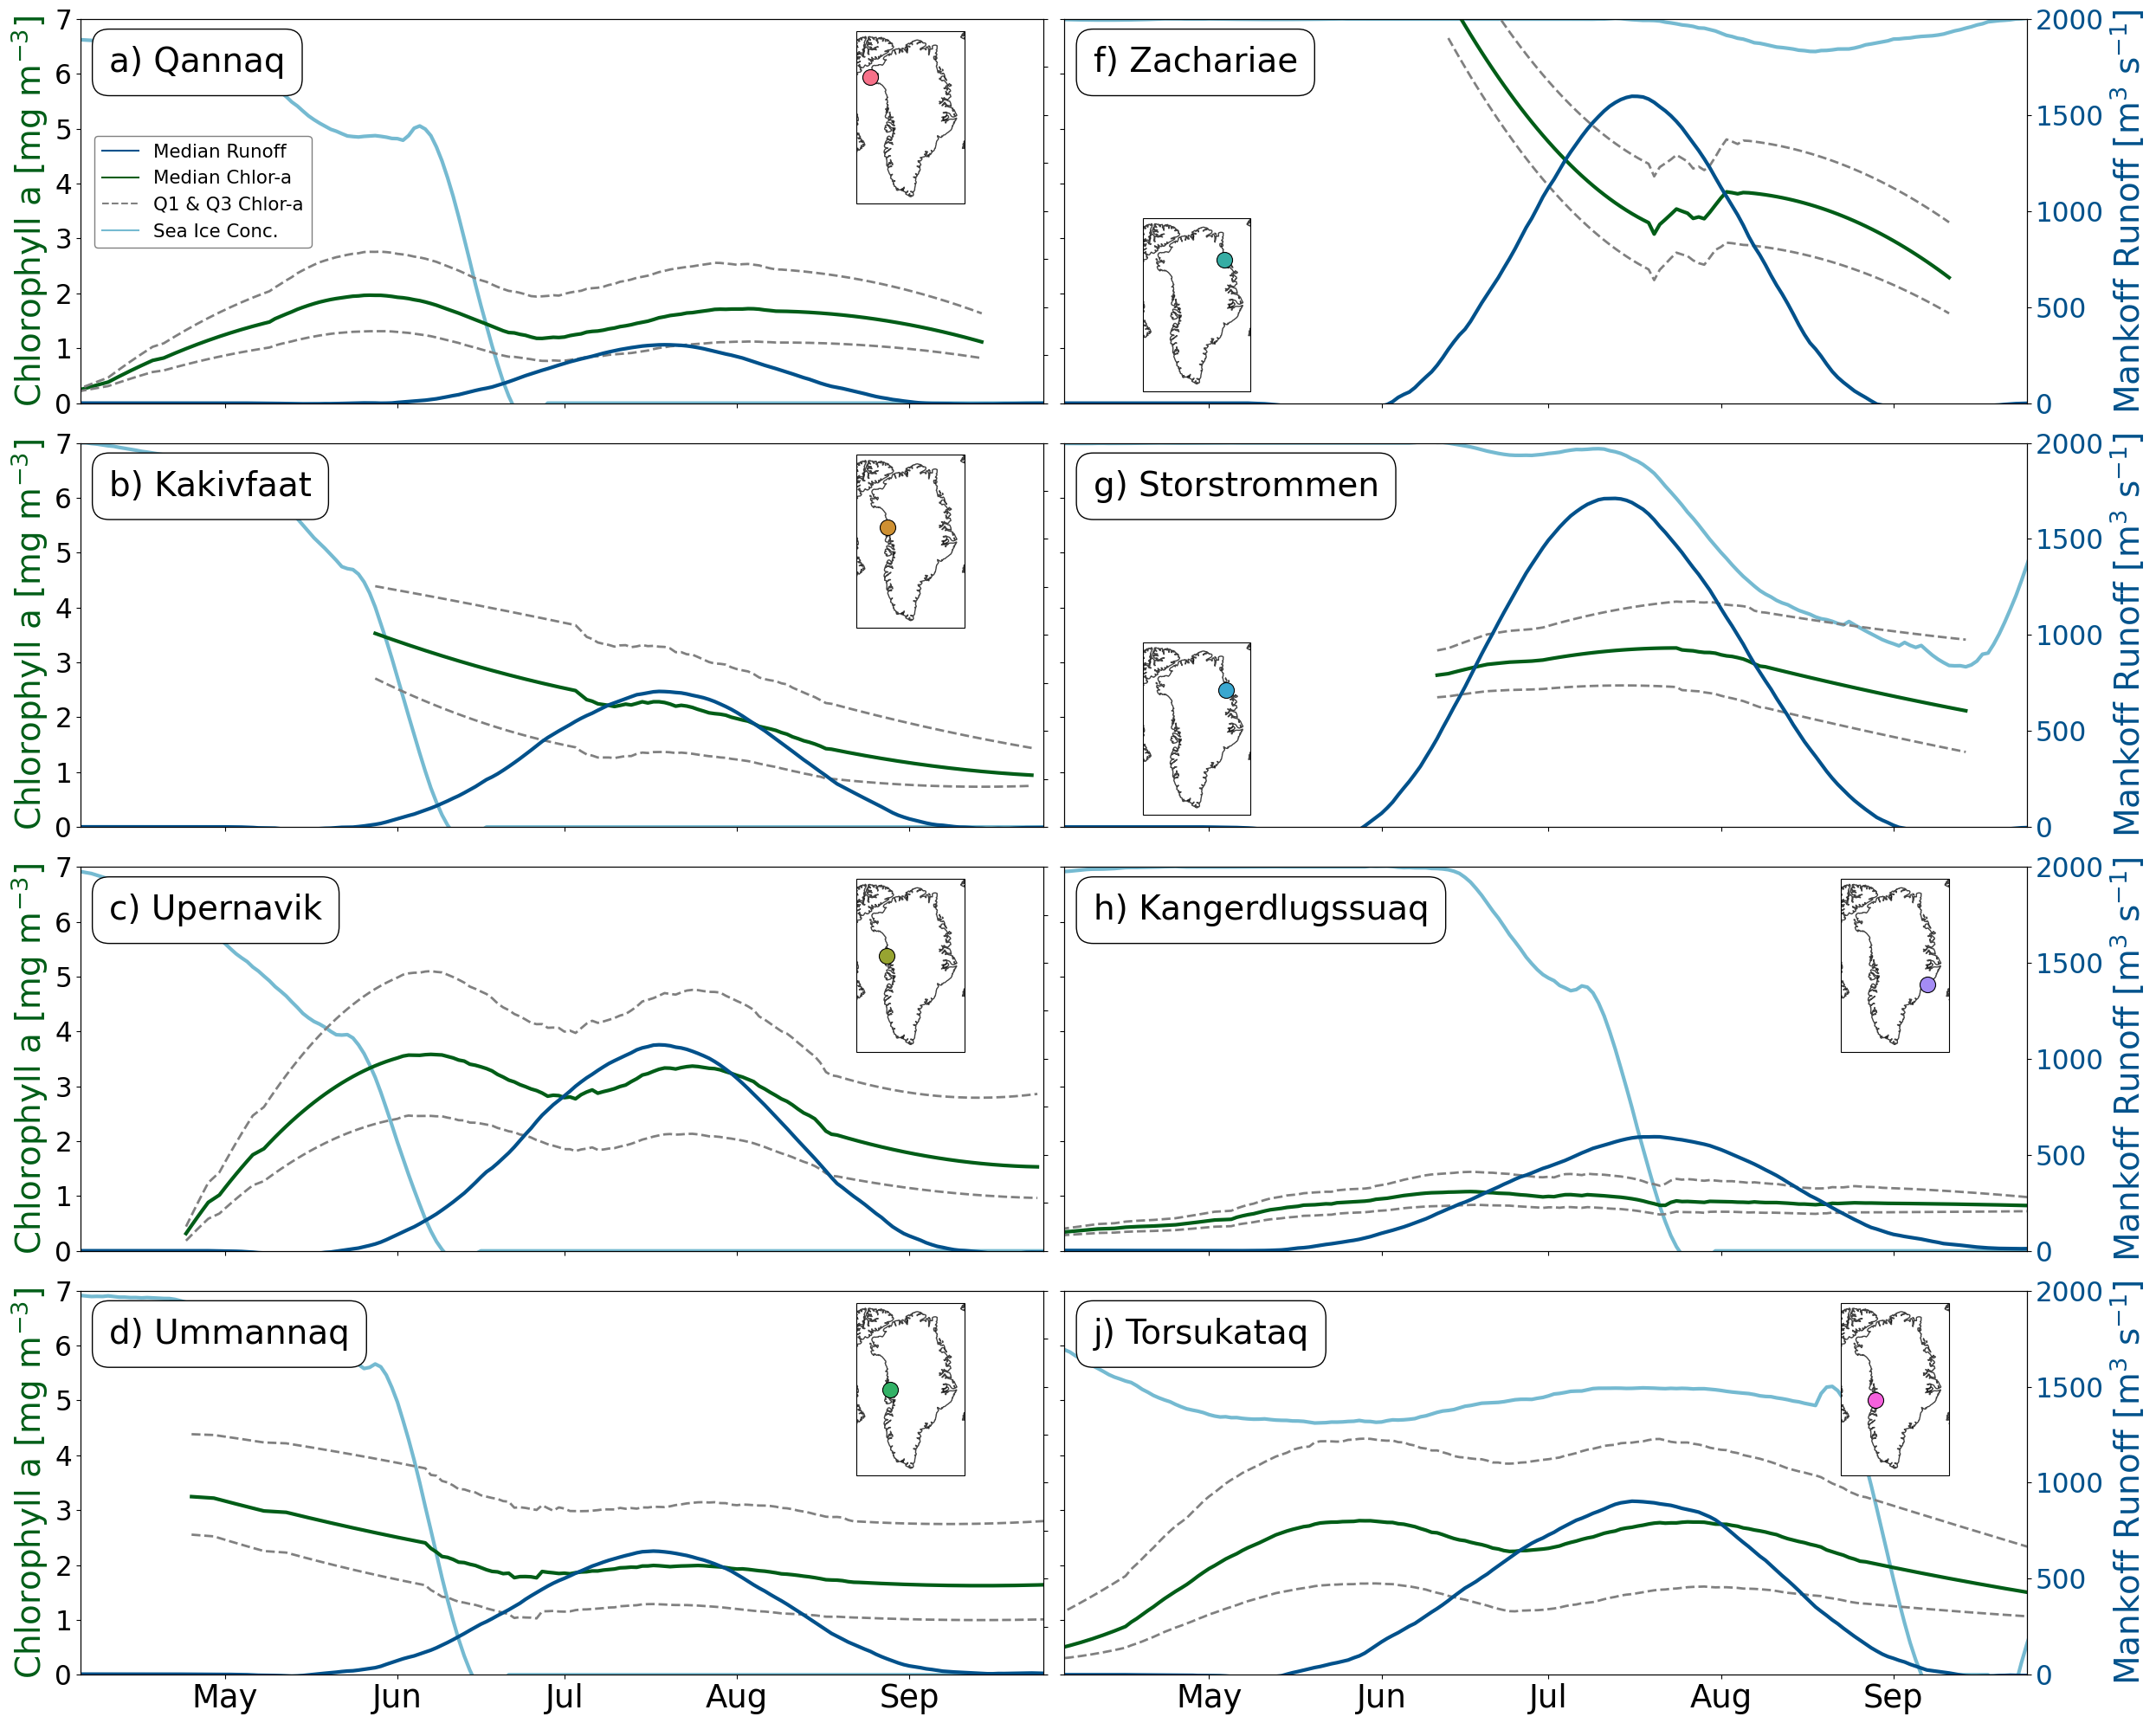

In [10]:
fig, axs = plt.subplots(4, 2, figsize=(25, 20), dpi=100)
axs = axs.flatten()


color_cycler = cycler(color=palette)
color_cycler_iter = iter(color_cycler)

for id in new_order[:]:
    color = next(color_cycler_iter)['color']
    index = id
    count += 1
    
    fjord_file = os.path.join(chla_fjord_folder, f'region{id}.csv')
    
    x_ind, y_ind = fjord_indexes[id]  

    # ~~~~~~ Mankoff Runoff ~~~~~~
    with open(filtered_data_fp + f'{id}_ice_total_discharge.pkl', 'rb') as f:
        total_discharge_ice = pickle.load(f)

    with open(filtered_data_fp + f'{id}_land_total_discharge.pkl', 'rb') as f:
        total_discharge_land = pickle.load(f)

    total_discharge = total_discharge_ice + total_discharge_land
    ds = total_discharge.to_dataset(name='discharge')
    ds['month'] = ds['time'].dt.month
    ds['day'] = ds['time'].dt.day

    ds['month_day'] = xr.DataArray(ds['month'] * 100 + ds['day'], dims='time')

    grouped_by_month_day = ds.groupby('month_day')
    median_discharge = grouped_by_month_day.median()['discharge']

    # messy dates 
    median_discharge['month_day'] = median_discharge['month_day'].astype(int)
    month = median_discharge['month_day'] // 100
    day = median_discharge['month_day'] % 100
    month_str = month.astype(str).str.zfill(2).to_pandas()
    day_str = day.astype(str).str.zfill(2).to_pandas()
    date_str = '2000-' + month_str + '-' + day_str
    median_discharge_dates = pd.to_datetime(date_str, format='%Y-%m-%d')
    median_discharge = median_discharge.assign_coords({'date': ('month_day', median_discharge_dates)})

    
    # ~~~~~~ Sea Ice Data ~~~~~~
    x_ind, y_ind = fjord_indexes[id]  
    fjord_seaice = seaice_daily_median.isel(x=x_ind, y=y_ind)

    seaice_window = 25
    fjord_seaice = convert_and_smooth(fjord_seaice, seaice_window)

    # ~~~~~~ Chlorophyll Data ~~~~~~
    if os.path.exists(fjord_file):
        fjord = pd.read_csv(fjord_file)
        fjord['time'] = pd.to_datetime(fjord['time'], unit='d', origin='unix')
        fjord['year'] = fjord['time'].dt.year 
        fjord['month'] = fjord['time'].dt.month
        fjord['day'] = fjord['time'].dt.day

        grouped = fjord.groupby(['month', 'day'])['chlor_a']
        fjord_median = grouped.median().reset_index()
        q1 = grouped.quantile(0.25).reset_index(name='q1')
        q3 = grouped.quantile(0.75).reset_index(name='q3')

        fjord = fjord_median.merge(q1, on=['month', 'day']).merge(q3, on=['month', 'day'])
        
        fjord['datetime'] = pd.to_datetime('2000-' + fjord['month'].astype(str) + '-' + fjord['day'].astype(str), format='%Y-%m-%d')

        chla_window = 84
        first_non_nan = fjord['datetime'].loc[fjord['chlor_a'].first_valid_index() + 5]
        last_non_nan = fjord['datetime'].loc[fjord['chlor_a'].last_valid_index() - 5]


        fjord['rollingmean'] = savgol_filter(fjord['chlor_a'], chla_window, 2)
        fjord['rollingmean_q1'] = savgol_filter(fjord['q1'], chla_window, 2)
        fjord['rollingmean_q3'] = savgol_filter(fjord['q3'], chla_window, 2)

        # set all values in fjord['rollingmean'] to nan where fjord['datetime'] is outside the range of first_non_nan and last_non_nan
        fjord['rollingmean'] = fjord['rollingmean'].where((fjord['datetime'] >= first_non_nan) & (fjord['datetime'] <= last_non_nan))
        fjord['rollingmean_q1'] = fjord['rollingmean_q1'].where((fjord['datetime'] >= first_non_nan) & (fjord['datetime'] <= last_non_nan))
        fjord['rollingmean_q3'] = fjord['rollingmean_q3'].where((fjord['datetime'] >= first_non_nan) & (fjord['datetime'] <= last_non_nan))

        # ~~~~~~ Plot Data ~~~~~~
        ax = axs[new_order.index(id)] 
        ax2 = ax.twinx()

        # chla
        ax.plot(fjord['datetime'], fjord['rollingmean'], label='Chlorophyll', color=chl_color, zorder = 5, linewidth=3)
        ax.plot(fjord['datetime'], fjord['rollingmean_q1'], label='Chlorophyll', color='grey', linestyle='--', zorder=5, linewidth=2)
        ax.plot(fjord['datetime'], fjord['rollingmean_q3'], label='Chlorophyll', color='grey', linestyle='--', zorder=5, linewidth=2)    
    
        # ice
        ax.plot(fjord_seaice.dayofyear, fjord_seaice*7, color=ice_color, linewidth=3)

        # runoff
        discharge_window=63
        median_discharge = convert_and_smooth(median_discharge, discharge_window, discharge=True)

        ax2.plot(median_discharge['date'], median_discharge, label='Mankoff Runoff', color=discharge_color, linewidth=3)
        ax2.set_xlim(start_date, end_date)
        ax2.set_ylim(0, 2000)
        ax2.set_ylabel('Mankoff Runoff Sum', color=discharge_color)
        ax2.tick_params(axis='y', labelcolor=discharge_color)

        ax.set_xlim(start_date, end_date)
        if count % 2 == 0:
            ax.set_ylabel('Chlorophyll a [mg m$^{-3}$]', fontsize=textfontsize, color=chl_color)
            ax.tick_params(axis='y', labelsize=textfontsize*.8)
            ax2.set_ylabel('')
            ax2.set_yticklabels([])
        else:
            ax.set_ylabel('')
            ax.set_yticklabels([])
            ax2.set_ylabel('Mankoff Runoff [m$^3$ s$^{-1}$]', fontsize=textfontsize)
            ax2.tick_params(axis='y', labelsize=textfontsize*.8)

        ax.set_ylim(0, 7)
        
        if count >= 6:
            ax.set_xlabel('')
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
            ax.xaxis.set_major_locator(mdates.MonthLocator())
            ax.tick_params(axis='x', labelsize=textfontsize*.95)
        else:
            ax.set_xlabel('')
            ax.tick_params(labelbottom=False)

    # create inset plot
    if count == 1 or count == 3:
        location = 'lower left'
    else:
        location = 'upper right'
        
    sub_ax = inset_axes(
    parent_axes=ax,
    width="25%",  
    height="45%",  
    loc=location,  

    borderpad=1,  
    axes_class=GeoAxes,  
    axes_kwargs={
        'projection': ccrs.Stereographic(central_longitude=-45, central_latitude=90),
        }
    )

    sub_ax.set_extent([-59, -29, 58, 85], crs=ccrs.PlateCarree())
    sub_ax.coastlines(alpha=0.75)

    sub_ax.plot(region_locations[id][0], region_locations[id][1], 'o', color=color, markersize=13, markeredgecolor='black', markeredgewidth=.8, transform=ccrs.PlateCarree())

    ax2.text(0.03, 0.93, f'{region_names_map[id]}', transform=ax.transAxes, fontsize=textfontsize, verticalalignment='top', horizontalalignment='left', bbox=dict(boxstyle="round,pad=0.5", edgecolor='black', facecolor='white', alpha=1), zorder=9999)
        

blue_line = mlines.Line2D([], [], color=discharge_color, markersize=20, label='Median Runoff')
black_line = mlines.Line2D([], [], color=chl_color, markersize=20, label='Median Chlor-a')
grey_line = mlines.Line2D([], [], color='grey', linestyle='--', markersize=20, label='Q1 & Q3 Chlor-a')
ice_line = mlines.Line2D([], [], color=ice_color, markersize=20, label='Sea Ice Conc.')

legend = axs[0].legend(handles=[blue_line, black_line, grey_line, ice_line], loc='center left', fontsize=textfontsize*.55, facecolor='white', edgecolor='grey',framealpha=1, bbox_to_anchor=(0.005, .55))
legend.set_zorder(9999)

# plt.suptitle('', y = .99, fontsize=textfontsize*1.2)
# plt.suptitle('Mean Chlorophyll-a, Freshwater Runoff, and Sea Ice Concentration in Fjords across Years', y = .99, fontsize=textfontsize*1.2)

plt.tight_layout()
# plt.savefig('/home/tara/Documents/mlml/poster/plots/smoothed_rolling_annuals', dpi=600)      
plt.show()


### Rolling Mean/Moving Average
For reference/comparison, here is the same figure with moving average instead of SavGol.

/tmp/ipykernel_78962/985963811.py:158: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


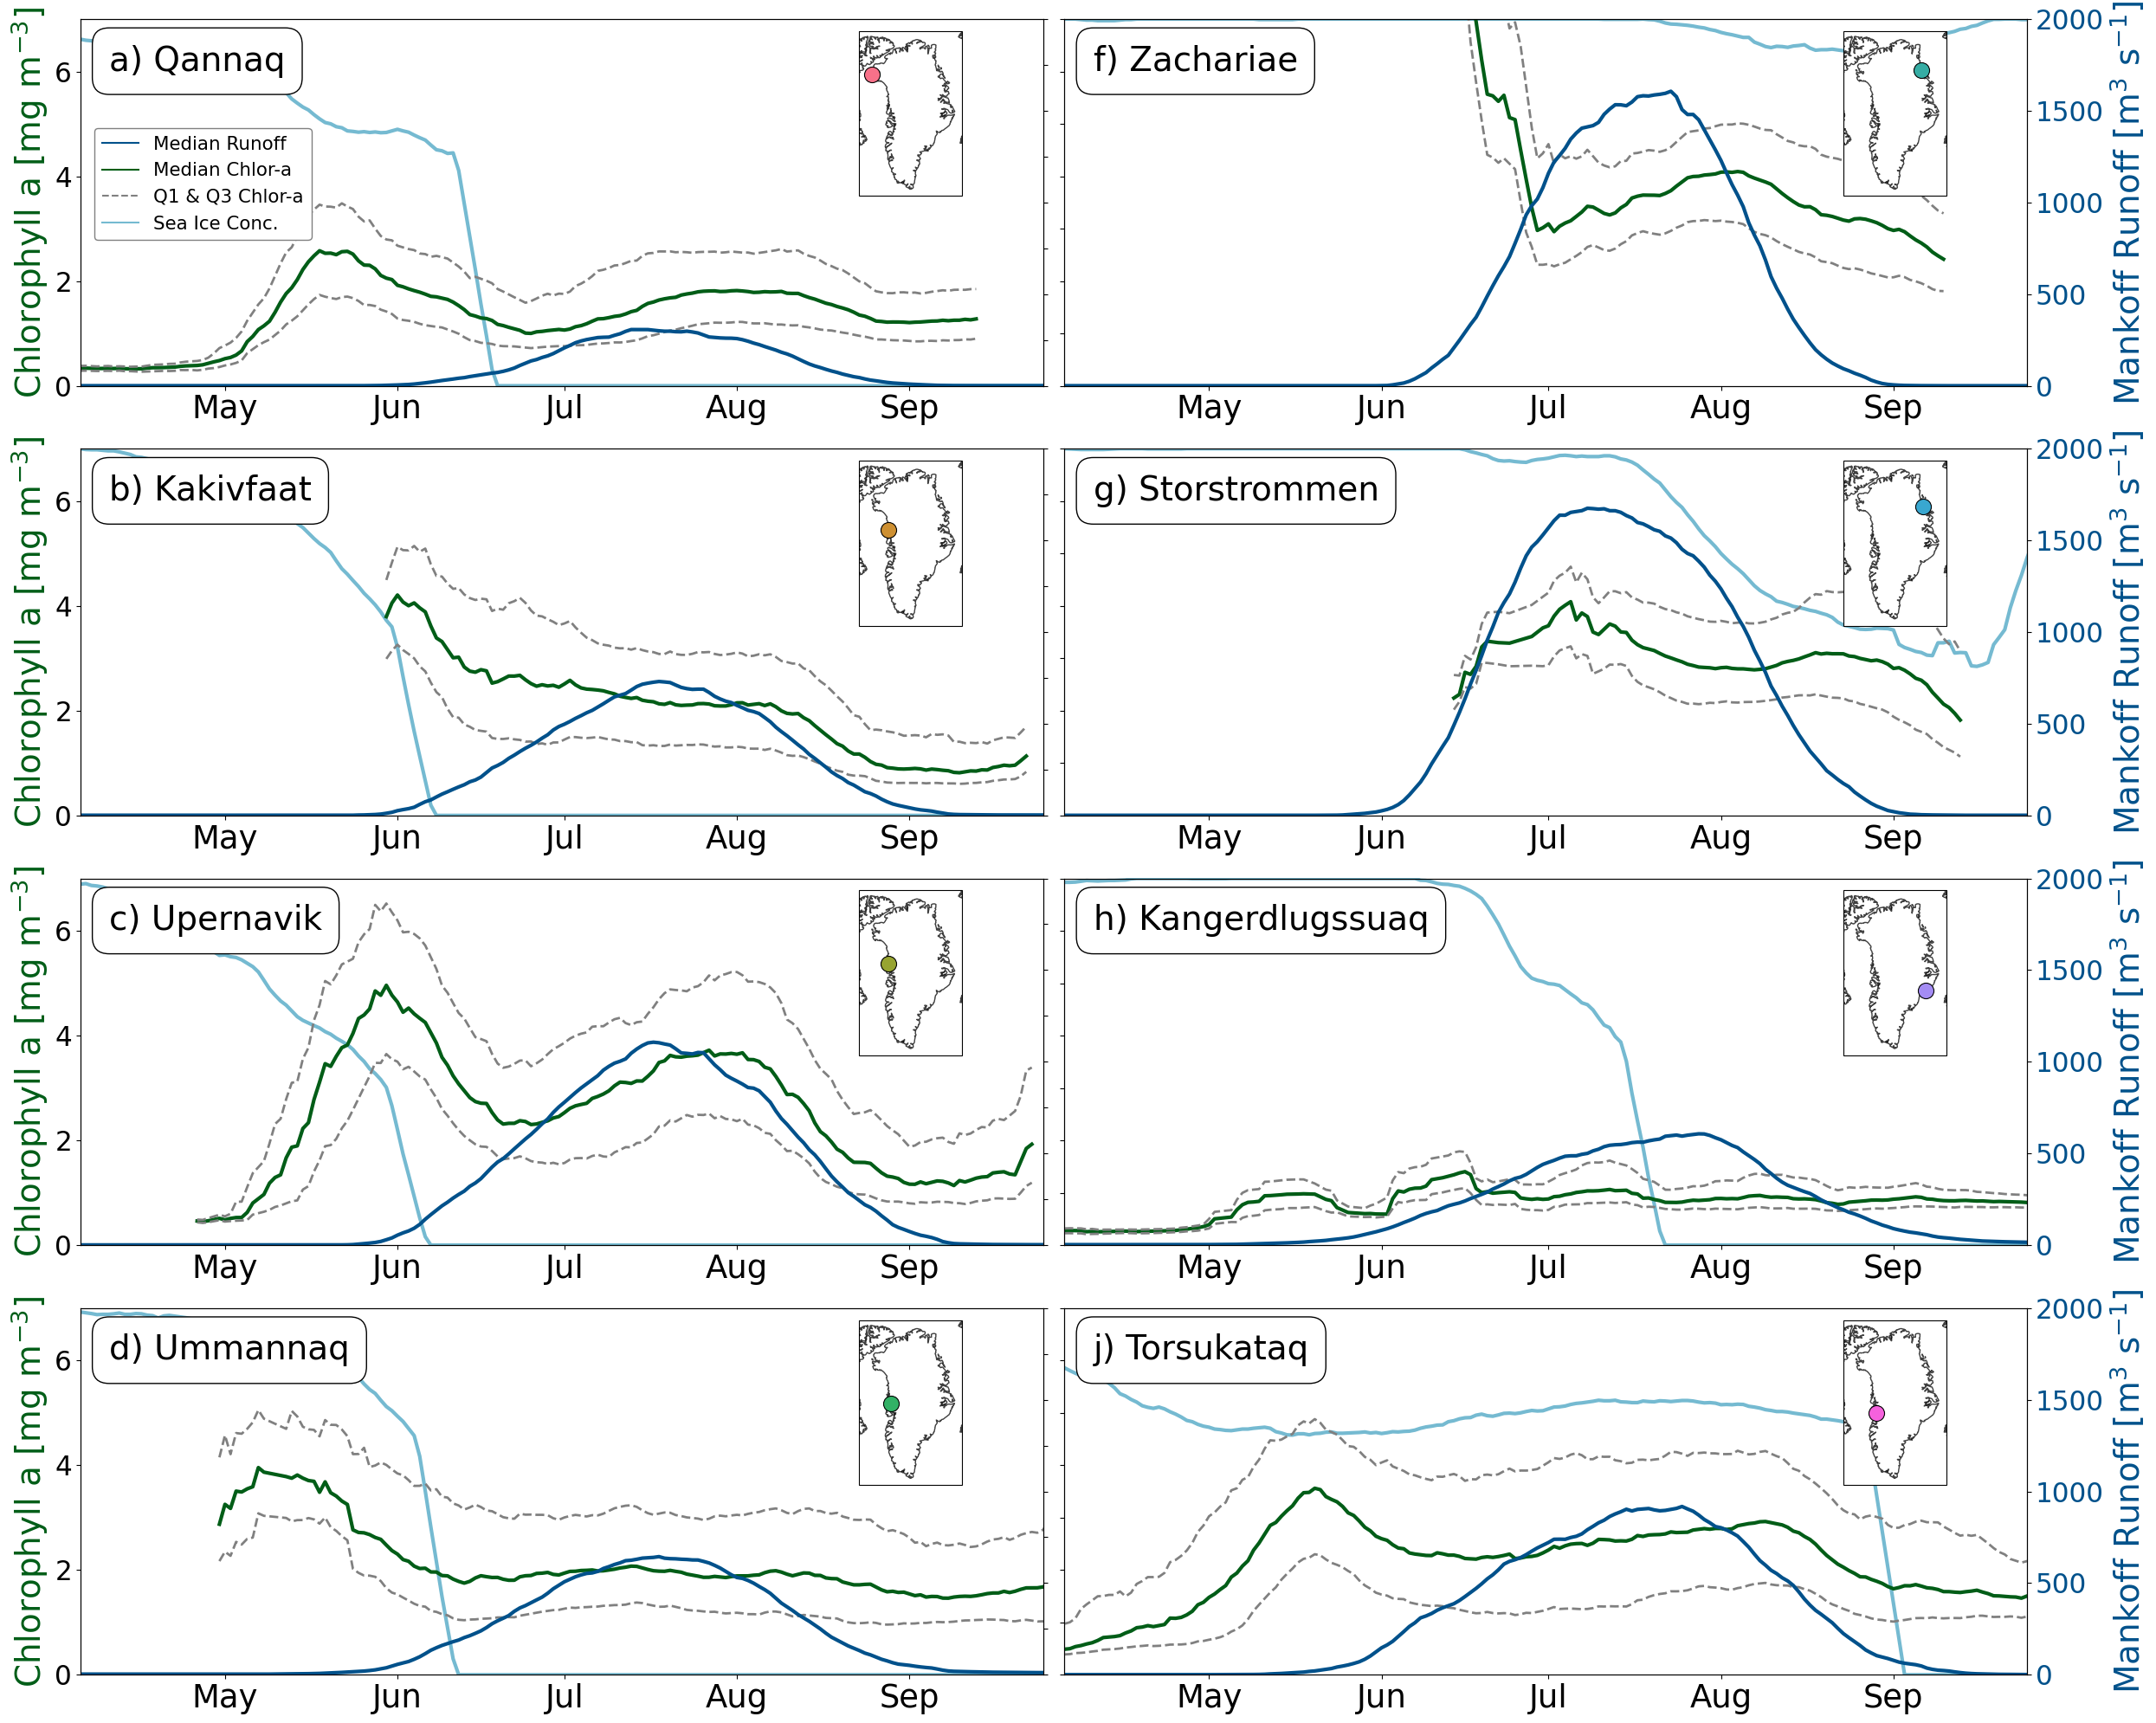

In [11]:
fig, axs = plt.subplots(4, 2, figsize=(25, 20), dpi=100)
axs = axs.flatten()

color_cycler = cycler(color=palette)
color_cycler_iter = iter(color_cycler)

for id in new_order[:]:
    color = next(color_cycler_iter)['color']
    index = id
    count += 1

    ## Chlorophyll Data    
    fjord_file = os.path.join(chla_fjord_folder, f'region{id}.csv')
    
    x_ind, y_ind = fjord_indexes[id]  

    # ~~~~~~ Mankoff Runoff ~~~~~~
    with open(filtered_data_fp + f'{id}_ice_total_discharge.pkl', 'rb') as f:
        total_discharge_ice = pickle.load(f)

    with open(filtered_data_fp + f'{id}_land_total_discharge.pkl', 'rb') as f:
        total_discharge_land = pickle.load(f)

    total_discharge = total_discharge_ice + total_discharge_land
    ds = total_discharge.to_dataset(name='discharge')
    ds['month'] = ds['time'].dt.month
    ds['day'] = ds['time'].dt.day

    ds['month_day'] = xr.DataArray(ds['month'] * 100 + ds['day'], dims='time')

    grouped_by_month_day = ds.groupby('month_day')
    median_discharge = grouped_by_month_day.median()['discharge']

    # messy dates
    median_discharge['month_day'] = median_discharge['month_day'].astype(int)
    month = median_discharge['month_day'] // 100
    day = median_discharge['month_day'] % 100
    month_str = month.astype(str).str.zfill(2).to_pandas()
    day_str = day.astype(str).str.zfill(2).to_pandas()
    date_str = '2000-' + month_str + '-' + day_str
    median_discharge_dates = pd.to_datetime(date_str, format='%Y-%m-%d')
    median_discharge = median_discharge.assign_coords({'date': ('month_day', median_discharge_dates)})

    

    # ~~~~~~ Sea Ice Data ~~~~~~
    seaice_window = 7
    x_ind, y_ind = fjord_indexes[id]  
    fjord_seaice = seaice_daily_median.isel(x=x_ind, y=y_ind)
    fjord_seaice = fjord_seaice.rolling(dayofyear=seaice_window, center=True).mean()
    
    fjord_seaice = seaice_dates(fjord_seaice)


    # ~~~~~~ Chlorophyll Data ~~~~~~
    if os.path.exists(fjord_file):
        fjord = pd.read_csv(fjord_file)
        fjord['time'] = pd.to_datetime(fjord['time'], unit='d', origin='unix')
        fjord['year'] = fjord['time'].dt.year #####
        fjord['month'] = fjord['time'].dt.month
        fjord['day'] = fjord['time'].dt.day

        grouped = fjord.groupby(['month', 'day'])['chlor_a']
        fjord_median = grouped.median().reset_index()
        q1 = grouped.quantile(0.25).reset_index(name='q1')
        q3 = grouped.quantile(0.75).reset_index(name='q3')

        fjord = fjord_median.merge(q1, on=['month', 'day']).merge(q3, on=['month', 'day'])

        chla_window = 14
        fjord['datetime'] = pd.to_datetime('2000-' + fjord['month'].astype(str) + '-' + fjord['day'].astype(str), format='%Y-%m-%d')
        fjord['rollingmean'] = fjord['chlor_a'].rolling(window=chla_window, center=True).mean()
        fjord['rollingmean_q1'] = fjord['q1'].rolling(window=chla_window, center=True).mean()
        fjord['rollingmean_q3'] = fjord['q3'].rolling(window=chla_window, center=True).mean()

        # ~~~~~~ Plot Data ~~~~~~
        ax = axs[new_order.index(id)] 
        # ax.scatter(fjord['datetime'], fjord['chlor_a'], label='Chlorophyll', color='red', zorder = 15, s=5)
        ax.plot(fjord['datetime'], fjord['rollingmean'], label='Chlorophyll', color=chl_color, zorder = 5, linewidth=3)
        ax.plot(fjord['datetime'], fjord['rollingmean_q1'], label='Chlorophyll', color='grey', linestyle='--', zorder=5, linewidth=2)
        ax.plot(fjord['datetime'], fjord['rollingmean_q3'], label='Chlorophyll', color='grey', linestyle='--', zorder=5, linewidth=2)    
    
        # ice
        ax.plot(fjord_seaice.dayofyear, fjord_seaice*7, color=ice_color, linewidth=3)

        ax2 = ax.twinx()

        runoff_window=14
        median_discharge = median_discharge.rolling(month_day=runoff_window, center=True).mean()

        ax2.plot(median_discharge['date'], median_discharge, label='Mankoff Runoff', color=discharge_color, linewidth=3)
        ax2.set_xlim(start_date, end_date)
        ax2.set_ylim(0, 2000)
        ax2.set_ylabel('Mankoff Runoff Sum', color=discharge_color)
        ax2.tick_params(axis='y', labelcolor=discharge_color)

        ax.set_xlim(start_date, end_date)
        if count % 2 == 0:
            ax.set_ylabel('Chlorophyll a [mg m$^{-3}$]', fontsize=textfontsize, color=chl_color)
            ax.tick_params(axis='y', labelsize=textfontsize*.8)
            ax2.set_ylabel('')
            ax2.set_yticklabels([])
        else:
            ax.set_ylabel('')
            ax.set_yticklabels([])
            ax2.set_ylabel('Mankoff Runoff [m$^3$ s$^{-1}$]', fontsize=textfontsize)
            ax2.tick_params(axis='y', labelsize=textfontsize*.8)

        ax.set_ylim(0, 7)
        
        if count >= 6:
            ax.set_xlabel('')
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
            ax.xaxis.set_major_locator(mdates.MonthLocator())
            ax.tick_params(axis='x', labelsize=textfontsize*.95)
        else:
            ax.set_xlabel('')
            ax.tick_params(labelbottom=False)

    #     # # create inset plot
    if count == 1 or count == 3:
        location = 'lower left'
    else:
        location = 'upper right'
        
    sub_ax = inset_axes(
    parent_axes=ax,
    width="25%",  
    height="45%",  
    loc=location,  

    borderpad=1,  
    axes_class=GeoAxes,  
    axes_kwargs={
        'projection': ccrs.Stereographic(central_longitude=-45, central_latitude=90),
        }
    )

    sub_ax.set_extent([-59, -29, 58, 85], crs=ccrs.PlateCarree())
    sub_ax.coastlines(alpha=0.75)

    sub_ax.plot(region_locations[id][0], region_locations[id][1], 'o', color=color, markersize=13, markeredgecolor='black', markeredgewidth=.8, transform=ccrs.PlateCarree())

    ax2.text(0.03, 0.93, f'{region_names_map[id]}', transform=ax.transAxes, fontsize=textfontsize, verticalalignment='top', horizontalalignment='left', bbox=dict(boxstyle="round,pad=0.5", edgecolor='black', facecolor='white', alpha=1), zorder=9999)

blue_line = mlines.Line2D([], [], color=discharge_color, markersize=20, label='Median Runoff')
black_line = mlines.Line2D([], [], color=chl_color, markersize=20, label='Median Chlor-a')
grey_line = mlines.Line2D([], [], color='grey', linestyle='--', markersize=20, label='Q1 & Q3 Chlor-a')
ice_line = mlines.Line2D([], [], color=ice_color, markersize=20, label='Sea Ice Conc.')
# legend = axs[2].legend(handles=[blue_line, black_line, grey_line, ice_line], loc='lower left', fontsize=textfontsize*.75, facecolor='white', edgecolor='grey',framealpha=1)
legend = axs[0].legend(handles=[blue_line, black_line, grey_line, ice_line], loc='center left', fontsize=textfontsize*.55, facecolor='white', edgecolor='grey',framealpha=1, bbox_to_anchor=(0.005, .55))
legend.set_zorder(9999)


# plt.suptitle('', y = .99, fontsize=textfontsize*1.2)
# plt.suptitle('Mean Chlorophyll-a, Freshwater Runoff, and Sea Ice Concentration in Fjords across Years', y = .99, fontsize=textfontsize*1.2)

plt.tight_layout()

# plt.savefig('/home/tara/Documents/mlml/poster/plots/smoothed_rolling_annuals', dpi=600)       # 
plt.show()
